In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
data_path = '/content/drive/MyDrive/dog_emotionn/images'

In [3]:
import os
import pandas as pd
class_names = sorted(os.listdir(data_path))
print(class_names)
num_classes = len(class_names)

['angry', 'happy', 'relaxed', 'sad']


In [4]:
import cv2
img_size = (224 , 224, 3)
import numpy as np
images = []
labels = []

for class_name in class_names:
  images_files_folder_name = os.path.join(data_path , class_name)
  if os.path.isdir(images_files_folder_name):
    for image_name in os.listdir(images_files_folder_name):
      if image_name.endswith('.jpg'):
        image_full_path = os.path.join(images_files_folder_name , image_name)
        #print(image_full_path)
        img = cv2.imread(image_full_path)
        img_cvt = cv2.cvtColor(img , cv2.COLOR_BGR2RGB)

        images.append(img_cvt)

        label = class_names.index(class_name)
        labels.append(label)
        #Image : /content/drive/MyDrive/dog_emotionn/images/sad/3570383695_bfea6ffdb5_b.jpg,label : 3

print(f"Total images : {len(images)} , Total labels : {len(labels)}")

Total images : 15921 , Total labels : 15921


In [ ]:
from sklearn.model_selection import train_test_split
X_train , X_val , y_train , y_val = train_test_split(images , labels , test_size = 0.2)

In [ ]:
import tensorflow as tf
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(factor = 0.05),
    tf.keras.layers.RandomFlip(mode = 'horizontal'),
    tf.keras.layers.RandomContrast(factor = 0.2)
])

In [ ]:
def preprocessing_image(image , label):
  image = tf.image.resize(image , img_size[:2])
  return image , label

def augment_image(image , label):
  image = data_augmentation(image)
  return image , label
def create_tensorflow_dataset(images ,labels , batch_size = 32 , buffer_size = 1000 , augment = False):
  dataset = tf.data.Dataset.from_tensor_slices((images , labels))
  dataset = dataset.map(preprocessing_image , num_parallel_calls = tf.data.AUTOTUNE)
  if augment:
    dataset = dataset.map(augment_image , num_parallel_calls = tf.data.AUTOTUNE)
  dataset = dataset.shuffle(buffer_size)
  dataset = dataset.batch(batch_size)
  dataset = dataset.prefetch(buffer_size = tf.data.AUTOTUNE)
  return dataset

In [ ]:
train_dataset = create_tensorflow_dataset(X_train , y_train , batch_size = 32 , buffer_size = len(X_train) , augment = True)
val_dataset = create_tensorflow_dataset(X_val , y_val , batch_size = 32 , buffer_size = len(X_val) , augment = False)

In [5]:
import tensorflow as tf
input_layer = tf.keras.layers.Input(shape=(224, 224, 3))
base_model = tf.keras.applications.EfficientNetB0(weights='imagenet', include_top=False, input_tensor= input_layer)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [7]:
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
output = tf.keras.layers.Dense(num_classes , activation = 'softmax')(avg)
model = tf.keras.Model(inputs = base_model.input , outputs = output)

In [8]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 224, 224, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 224, 224, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 32)   │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 32)   │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 32)   │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 32)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand    

 Total params: 4,054,695 (15.47 MB)

 Trainable params: 4,012,672 (15.31 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [ ]:
for layer in base_model.layers:
  layer.trainable = False
optimizer = tf.keras.optimizers.Adam()
model.compile(loss = 'sparse_categorical_crossentropy' , optimizer = optimizer , metrics = ['accuracy'])
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss' , patience = 15)
history = model.fit(train_dataset , epochs = 60 , validation_data = val_dataset , callbacks = [early_stopping_cb])

Epoch 1/60
498/498 ━━━━━━━━━━━━━━━━━━━━ 56s 76ms/step - accuracy: 0.4322 - loss: 1.2483 - val_accuracy: 0.5359 - val_loss: 1.0794
Epoch 2/60
498/498 ━━━━━━━━━━━━━━━━━━━━ 19s 38ms/step - accuracy: 0.5381 - loss: 1.0926 - val_accuracy: 0.5614 - val_loss: 1.0384
Epoch 3/60
498/498 ━━━━━━━━━━━━━━━━━━━━ 19s 38ms/step - accuracy: 0.5552 - loss: 1.0643 - val_accuracy: 0.5661 - val_loss: 1.0157
Epoch 4/60
498/498 ━━━━━━━━━━━━━━━━━━━━ 19s 38ms/step - accuracy: 0.5643 - loss: 1.0394 - val_accuracy: 0.5852 - val_loss: 1.0052
Epoch 5/60
498/498 ━━━━━━━━━━━━━━━━━━━━ 19s 38ms/step - accuracy: 0.5760 - loss: 1.0223 - val_accuracy: 0.5805 - val_loss: 0.9874
Epoch 6/60
498/498 ━━━━━━━━━━━━━━━━━━━━ 19s 38ms/step - accuracy: 0.5744 - loss: 1.0235 - val_accuracy: 0.5931 - val_loss: 0.9851
Epoch 7/60
498/498 ━━━━━━━━━━━━━━━━━━━━ 19s 38ms/step - accuracy: 0.5861 - loss: 1.0102 - val_accuracy: 0.6060 - val_loss: 0.9716
Epoch 8/60
498/498 ━━━━━━━━━━━━━━━━━━━━ 19s 38ms/step - accuracy: 0.5863 - loss: 0.9950 - 

In [ ]:
#동결 해제 후 다시 훈련하기.
for layer in base_model.layers[-30:]:
  layer.trainable = True
optimizer = tf.keras.optimizers.Adam()
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss' , patience = 15)
model.compile(loss = 'sparse_categorical_crossentropy' , optimizer = optimizer , metrics = ['accuracy'])
history = model.fit(train_dataset , epochs = 60 , validation_data = val_dataset , callbacks = [early_stopping_cb])

Epoch 1/60
498/498 ━━━━━━━━━━━━━━━━━━━━ 71s 88ms/step - accuracy: 0.5040 - loss: 1.2944 - val_accuracy: 0.6722 - val_loss: 0.8312
Epoch 2/60
498/498 ━━━━━━━━━━━━━━━━━━━━ 22s 43ms/step - accuracy: 0.6353 - loss: 0.8991 - val_accuracy: 0.7721 - val_loss: 0.6093
Epoch 3/60
498/498 ━━━━━━━━━━━━━━━━━━━━ 22s 44ms/step - accuracy: 0.7170 - loss: 0.7320 - val_accuracy: 0.8641 - val_loss: 0.4080
Epoch 4/60
498/498 ━━━━━━━━━━━━━━━━━━━━ 22s 44ms/step - accuracy: 0.7874 - loss: 0.5586 - val_accuracy: 0.9042 - val_loss: 0.2905
Epoch 5/60
498/498 ━━━━━━━━━━━━━━━━━━━━ 22s 44ms/step - accuracy: 0.8493 - loss: 0.4070 - val_accuracy: 0.9334 - val_loss: 0.2007
Epoch 6/60
498/498 ━━━━━━━━━━━━━━━━━━━━ 22s 44ms/step - accuracy: 0.8881 - loss: 0.3158 - val_accuracy: 0.9538 - val_loss: 0.1378
Epoch 7/60
498/498 ━━━━━━━━━━━━━━━━━━━━ 22s 44ms/step - accuracy: 0.9102 - loss: 0.2642 - val_accuracy: 0.9755 - val_loss: 0.0991
Epoch 8/60
498/498 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.9198 - loss: 0.2219 - 

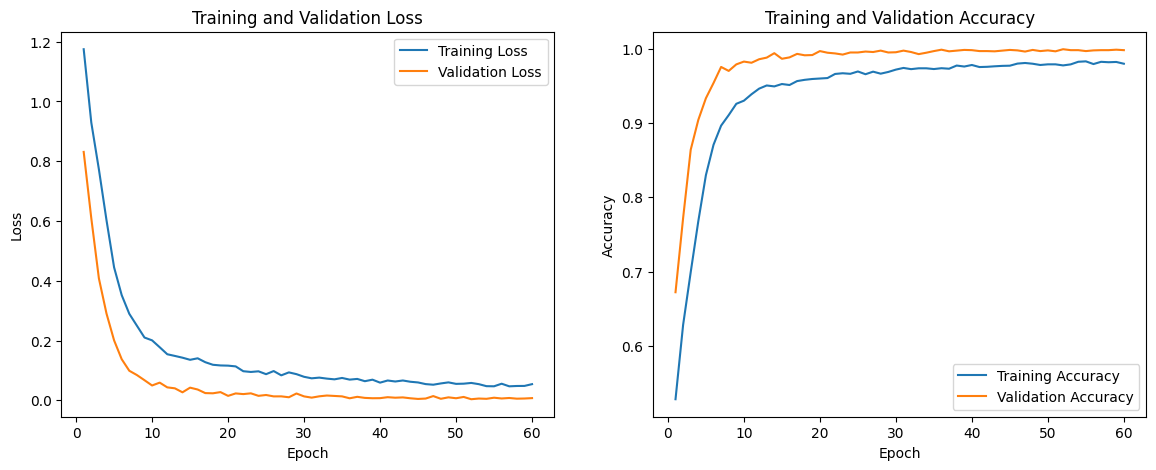

In [ ]:
history = history.history
loss = history['loss']
val_loss = history['val_loss']
accuracy = history['accuracy']
val_accuracy = history['val_accuracy']

epochs = range(1 , len(loss) + 1)
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))

plt.subplot(121)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(122)
plt.plot(epochs, accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()

In [ ]:
model.save('/content/drive/MyDrive/dog_emotionn/dog_emotion_with_efficientnet.keras')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step


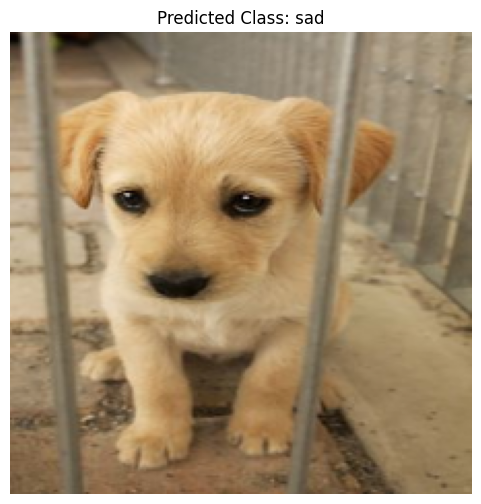

[[9.1966128e-01 2.3860534e-07 1.0328200e-03 9.9079308e+01]]
['angry', 'happy', 'relaxed', 'sad']


In [13]:
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

test_image_path = '/content/drive/MyDrive/saddog.jpg'

def load_and_preprocess_image(image_path, target_size):
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError("이미지 오류")
    img_resized = cv2.resize(img, target_size[:2])
    img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)
    img_array = np.asarray(img_rgb)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array


target_size = (224, 224)
test_img_array = load_and_preprocess_image(test_image_path, target_size)


predictions = model.predict(test_img_array)
predicted_class = np.argmax(predictions, axis=1)[0]


class_names = sorted(os.listdir(data_path))
if 'labels.csv' in class_names:
    class_names.remove('labels.csv')
    class_names.remove('real_final_dog_emotion.keras')
predicted_class_name = class_names[predicted_class]


plt.figure(figsize=(6, 6))
plt.imshow(test_img_array[0].astype('uint8'))
plt.title(f'Predicted Class: {predicted_class_name}')
plt.axis('off')
plt.show()
print(predictions * 100)
print(class_names)